In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import tensorflow as tf
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

In [3]:
# To download dataset from google drive folder


In [4]:
sample_size = 450
width = 150
height = 150

In [5]:
files = ['A', 'B', 'C']
file_path = "C:/laragon/www/Project/Bloomy/dataset/{}"
data = {}
for f in files:
    data[f]=[]
for col in files:
    os.chdir(file_path.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpg'):
            data[col].append(i)
        if i.endswith('.png'):
            data[col].append(i)

In [6]:
print(len(data['A']))
print(len(data['B']))
print(len(data['C']))

150
150
150


In [7]:
pd.DataFrame(data).head()

,A,B,C
0,IMG20230517080311_jpg.rf.3451cb7a64a92fbac41b5...,IMG20230517091317_jpg.rf.083cb507bb4840c79d68d...,01_jpg.rf.1b963e5ab9223aeb4afa33f58184af76-rem...
1,IMG20230517080311_jpg.rf.4581690921b38e87fe05d...,IMG20230517091317_jpg.rf.33b6ea9f5f4bd3c88f7f5...,01_jpg.rf.ea7e1c9af777a8c99d8daed8dfed0371-rem...
2,IMG20230517080311_jpg.rf.ac321ed0d06597f17e5b5...,IMG20230517091317_jpg.rf.74bc8142ad28cac66279a...,02_jpg.rf.4b8047d6e8dbd2b2abaf2edd133c9870-rem...
3,IMG20230518073006_jpg.rf.282e6290c6e36f85e91ff...,IMG20230517135103_jpg.rf.86ecc0e202a985beceb16...,03_jpg.rf.112b55c5d0d77e5838ebaf6e26cfc053-rem...
4,IMG20230518073006_jpg.rf.369195516dd07c6c088a7...,IMG20230517135103_jpg.rf.979d18f7af68b6ac8efb0...,06_jpg.rf.bc7f9dc014c941fda44b7133247b73a4-rem...


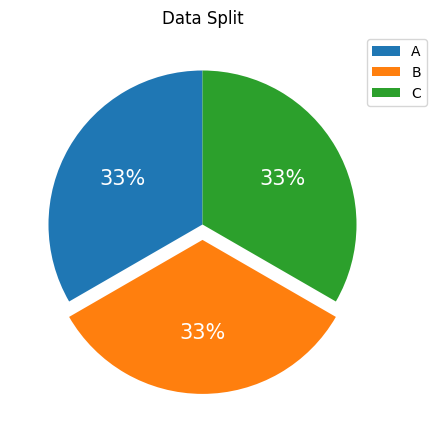

In [8]:
sizes = [len(data['A']), len(data['B']), len(data['C'])]
explode = (0, 0.1, 0) 

plt.figure(figsize=(10, 5), dpi=100)
plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color': "w", "fontsize": 15}, startangle=90, explode=explode)
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Data Split")
plt.show()

In [9]:
start = time.time()
image_data = []
image_target = []

for title in files:
    os.chdir(file_path.format(title))
    counter = 0
    for i in data[title]:
        img = cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(cv2.resize(img,(width, height)))
        image_target.append(title)
        counter += 1
        if counter == sample_size:
            break
    clear_output(wait=True)
    print("Compiled Class",title)
calculate_time = time.time() - start
print("Calculate Time",round(calculate_time,5))

Compiled Class C
Calculate Time 15.97454


In [10]:
image_data = np.array(image_data)
size = image_data.shape[0]
image_data.shape

(450, 150, 150, 3)

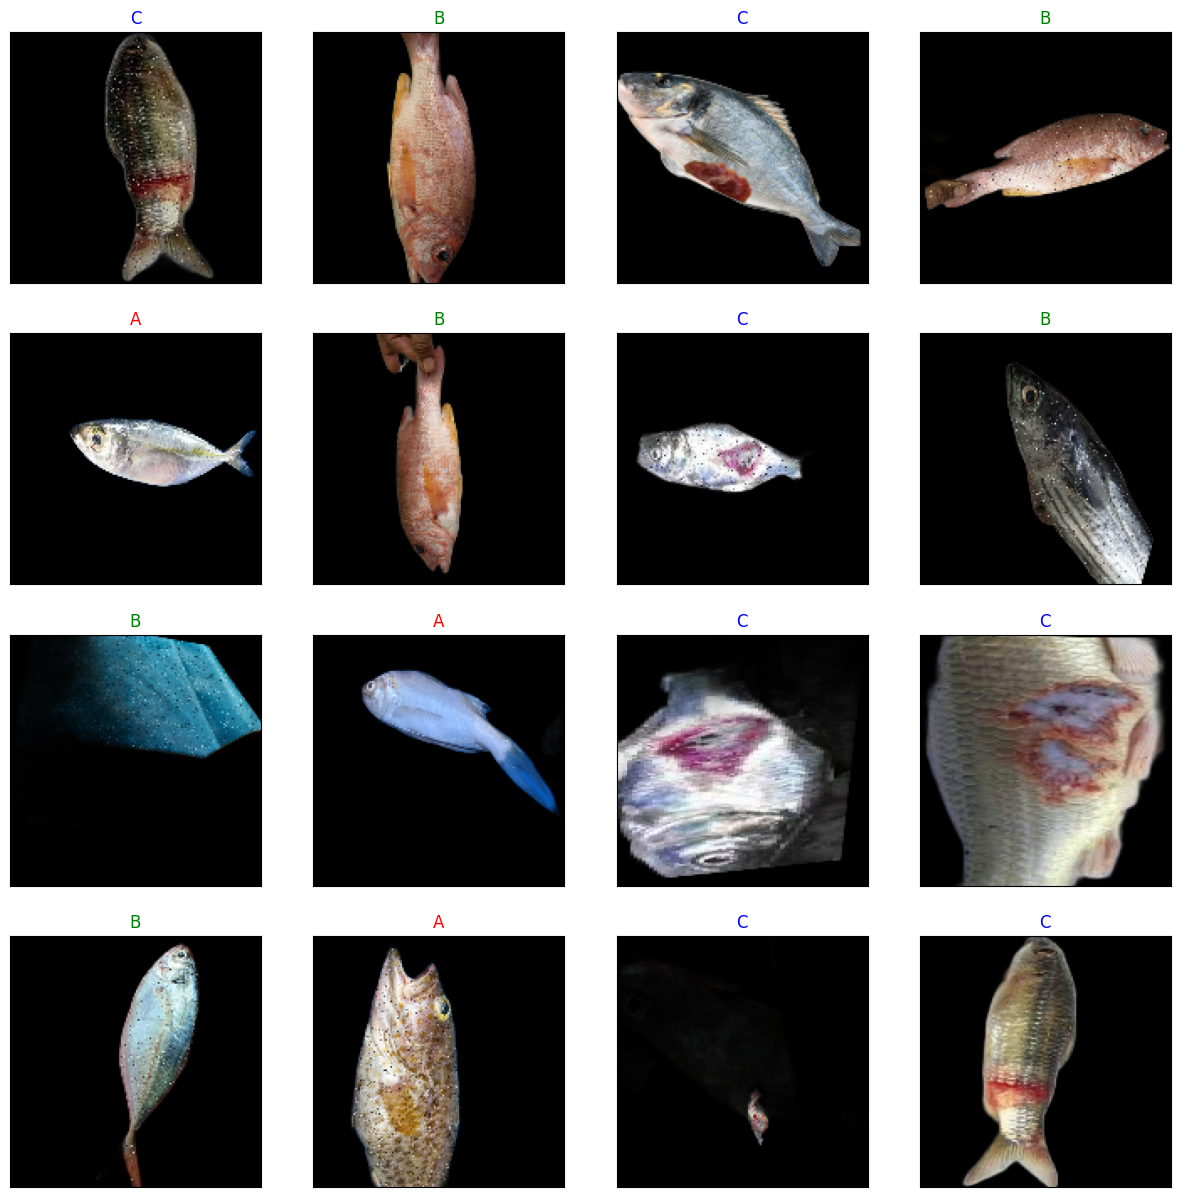

In [11]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [12]:
labels = LabelEncoder()
labels.fit(image_target)

LabelEncoder()

In [13]:
X = image_data / 255.0
y = labels.transform(image_target)
train_images, test_images, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=123)


In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(width, height, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


In [15]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.4),
#     tf.keras.layers.Dense(3, activation='softmax')
# ])

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

In [16]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                                 patience=10,
#                                                 restore_best_weights=True)


In [17]:
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=100,
#                     validation_data=(test_images, test_labels), callbacks=[callback])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def lr_scheduler(epoch):
    return 0.001 * np.exp(-0.1 * epoch)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels, epochs=100, validation_data=(test_images, test_labels), callbacks=[lr_callback])

Epoch 1/100
10/10 [==============================] - 11s 153ms/step - loss: 1.2101 - accuracy: 0.5175 - val_loss: 0.8042 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 0s 40ms/step - loss: 0.6915 - accuracy: 0.7079 - val_loss: 0.4855 - val_accuracy: 0.7926 - lr: 9.0484e-04
Epoch 3/100
10/10 [==============================] - 0s 43ms/step - loss: 0.4559 - accuracy: 0.8159 - val_loss: 0.4811 - val_accuracy: 0.7778 - lr: 8.1873e-04
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 0.3857 - accuracy: 0.8635 - val_loss: 0.4695 - val_accuracy: 0.7852 - lr: 7.4082e-04
Epoch 5/100
10/10 [==============================] - 0s 44ms/step - loss: 0.3194 - accuracy: 0.8984 - val_loss: 0.4415 - val_accuracy: 0.8148 - lr: 6.7032e-04
Epoch 6/100
10/10 [==============================] - 0s 41ms/step - loss: 0.3197 - accuracy: 0.8667 - val_loss: 0.4141 - val_accuracy: 0.8370 - lr: 6.0653e-04
Epoch 7/100
10/10 [=============================

5/5 - 0s - loss: 0.4005 - accuracy: 0.8667 - 130ms/epoch - 26ms/step


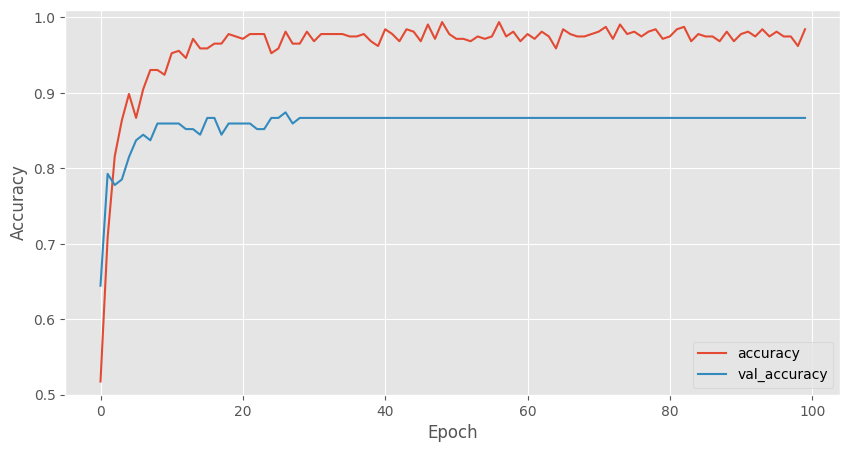

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.01])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [19]:
result=model.evaluate(test_images, test_labels)

5/5 [==============================] - 0s 23ms/step - loss: 0.4005 - accuracy: 0.8667


In [20]:
for i in range(len(model.metrics_names)):
    print(model.metrics_names[i],":",result[i])

loss : 0.4004897177219391
accuracy : 0.8666666746139526


In [21]:
# model.summary()

5/5 [==============================] - 1s 21ms/step


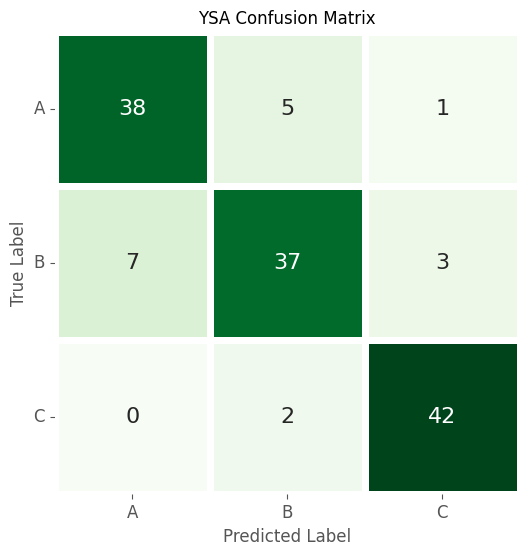

In [22]:
y_pred = model.predict(test_images)

def toClass(pred):

    class_ = np.zeros(len(pred))
    for i in range(len(pred)):
        index = pred[i].argmax()
        class_[i] = index

    return class_

cm = confusion_matrix(test_labels,toClass(y_pred))

df1 = pd.DataFrame(columns=["A","B", "C"], index= ["A","B", "C"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Greens", fmt= '.0f',ax=ax,linewidths = 5, cbar = False,annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("YSA Confusion Matrix", size = 12)
plt.show()

In [23]:
def Prediction(image):

    global width, height, files, labels

    img = cv2.resize(image,(width,height))

    test = img / 255.0

    pred = model.predict(np.array([image])).argmax()

    return labels.inverse_transform([pred])[0]

1/1 [==============================] - 0s 26ms/step


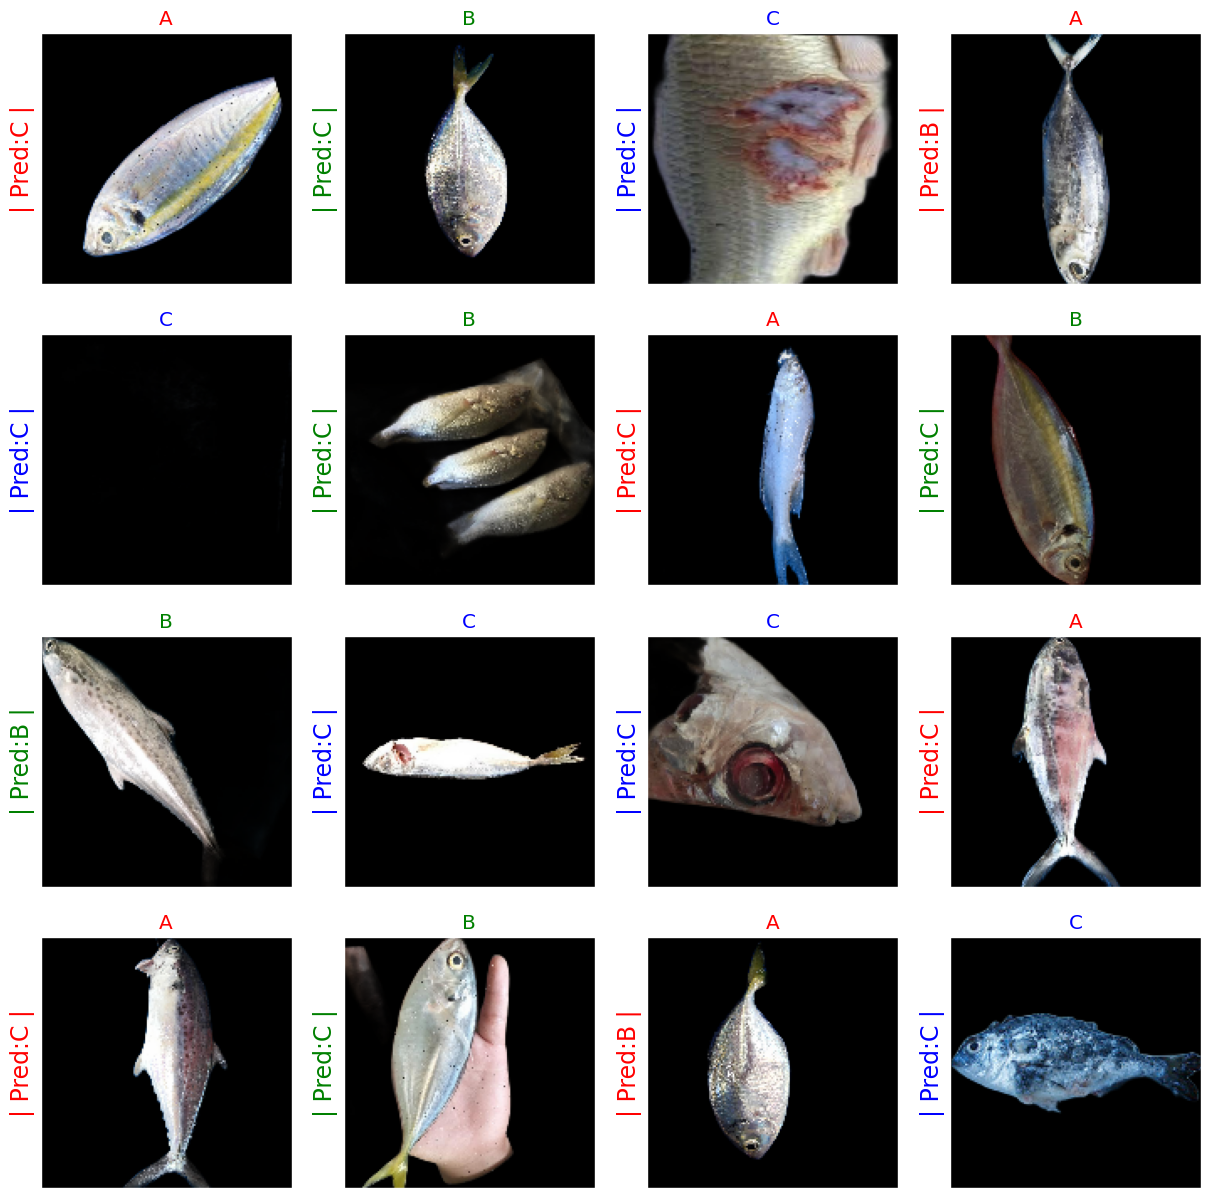

In [24]:
plt.figure(figsize=(15,15))
for i in range(1,17):
    fig = np.random.choice(np.arange(size))
    plt.subplot(4,4,i)
    plt.imshow(image_data[fig])
    if image_target[fig]=='A':
        c='red'
    elif image_target[fig]=='B':
        c='green'
    else:
        c='blue'
    plt.title(image_target[fig], color=c)
    plt.ylabel("| Pred:{} |".format(Prediction(image_data[fig])),fontsize=17, color=c)
    plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
import os
import rembg

# input folder  = where is the image located
# output folder = pick the different folder
input_folder = "img/"
output_folder = "img/output/"

for index, file in enumerate(os.listdir(input_folder)):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        name, ext = os.path.splitext(file)
        input_path = os.path.join(input_folder, file)
        output_path = os.path.join(output_folder, f"{name}-rem.png")
        
        with open(input_path, "rb") as inp:
            with open(output_path, "wb") as out:
                input_data = inp.read()
                output_data = rembg.remove(input_data)
                out.write(output_data)
        
        print(f'done {index+1}')

1/1 [==============================] - 0s 31ms/step
Prediction range:
Minimum value: 0.0007932635
Maximum value: 0.65309364
Grade: B
Medium


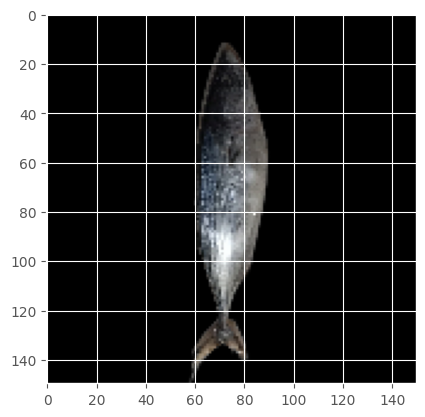

In [54]:


user_path = r"C:\laragon\www\Project\Bloomy\img\output"

image_files = os.listdir(user_path)

index = 10
image_file = os.path.join(user_path, image_files[index])

img = image.load_img(image_file, target_size=(150, 150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0 

classes = model.predict(x, batch_size=1)
nilai_min = np.min(classes)
nilai_max = np.max(classes)

print("Prediction range:")
print("Minimum value:", nilai_min)
print("Maximum value:", nilai_max)

class_list = ['A', 'B', 'C'] 

predicted_class = class_list[np.argmax(classes[0])]
print('Grade:', predicted_class)

if predicted_class == 'A':
    print('Good')
   

elif predicted_class == 'B':
    print('Medium')


elif predicted_class == 'C':
    print('Bad')

In [26]:
# file_location = 'D:\\Users\\Andra\Documents\\Bloomy\\prototype\\fish_grading.h5'
file_location = 'C:\laragon\www\Project\Bloomy\model\\fishgrading.h5'

model.save(file_location)